Following steps from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
# Import Dataset
df = pd.read_csv('./data/Womens Clothing E-Commerce Reviews_clean.csv', index_col=0)
df.head()

,clothing_id,age,review_text,rating,recommended,pos_feedback_count,division,department,class,polarity,subjectivity,review_char,review_words,sentiment
0,767,33,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,0.633333,0.933333,53,8,1
1,1080,34,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,0.339583,0.725000,303,62,1
2,1077,60,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,0.073675,0.356294,500,98,1
3,1049,50,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,0.550000,0.625000,124,22,1
4,847,47,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,0.512891,0.568750,192,36,1


In [3]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'and'])

In [4]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(df['review_text']))

print(data_words[0])

['absolutely', 'wonderful', 'silky', 'and', 'sexy', 'and', 'comfortable']


In [5]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['absolutely', 'wonderful', 'silky', 'and', 'sexy', 'and', 'comfortable']


In [6]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [7]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[0])

['absolutely', 'wonderful', 'silky', 'comfortable']


In [8]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[0])

[(0, 1), (1, 1), (2, 1), (3, 1)]


Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).

For example, (0, 1) above implies, word id 0 occurs once in the first document. Likewise, word id 1 occurs twice and so on.

This is used as the input by the LDA model.

If you want to see what word a given id corresponds to, pass the id as a key to the dictionary.

In [9]:
id2word[0]

'absolutely'

In [10]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('absolutely', 1), ('comfortable', 1), ('silky', 1), ('wonderful', 1)]]

In [11]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [12]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.062*"dress" + 0.049*"wear" + 0.046*"love" + 0.034*"color" + 0.030*"great" '
  '+ 0.021*"buy" + 0.020*"well" + 0.019*"get" + 0.018*"flattering" + '
  '0.017*"perfect"'),
 (1,
  '0.072*"size" + 0.058*"fit" + 0.040*"small" + 0.032*"order" + 0.027*"go" + '
  '0.026*"little" + 0.025*"try" + 0.024*"large" + 0.022*"run" + 0.022*"long"'),
 (2,
  '0.054*"look" + 0.044*"top" + 0.031*"would" + 0.028*"fabric" + 0.023*"make" '
  '+ 0.018*"much" + 0.015*"nice" + 0.015*"good" + 0.015*"also" + 0.015*"back"'),
 (3,
  '0.098*"pant" + 0.071*"pair" + 0.036*"thick" + 0.029*"end" + 0.028*"lace" + '
  '0.021*"heel" + 0.020*"cotton" + 0.016*"wardrobe" + 0.014*"walk" + '
  '0.014*"version"'),
 (4,
  '0.039*"blouse" + 0.037*"low" + 0.031*"slip" + 0.025*"thought" + '
  '0.022*"belt" + 0.022*"elastic" + 0.018*"today" + 0.017*"available" + '
  '0.016*"curve" + 0.015*"cardigan"')]


In [13]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.579938113436239

Coherence Score:  0.32297281038610515


In [14]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.211885 -0.259096       1        1  36.783344
2      0.188496 -0.056066       2        1  30.599678
1      0.126770  0.380524       3        1  25.496555
4     -0.264261 -0.032694       4        1   3.638206
3     -0.262890 -0.032667       5        1   3.482228, topic_info=           Term          Freq         Total Category  logprob  loglift
46         size  10099.000000  10099.000000  Default  30.0000  30.0000
6         dress  12711.000000  12711.000000  Default  29.0000  29.0000
30          fit   8265.000000   8265.000000  Default  28.0000  28.0000
102        look   9231.000000   9231.000000  Default  27.0000  27.0000
59         wear   9887.000000   9887.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
2036  expensive    125.798317    126.606148   Topic5  -5.0326   3.3511
649       bring    126.400215    127.212730   Topic5  -5.0279   3.3511
2         silky    120.540466    121.351654   Topic5  -5.0753   3.3508
776        cuff    117.173203    117.977875   Topic5  -5.1037   3.3507
905         hug    110.322098    111.132370   Topic5  -5.1639   3.3502

[211 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1174      5  0.994870   addition
115       2  0.999777       also
642       3  0.999474        arm
1385      4  0.998666  available
293       4  0.995637    awkward
...     ...       ...        ...
23        2  0.955123      would
23        3  0.044642      would
255       4  0.995919      wrong
529       4  0.996338        yet
54        4  0.995871        zip

[221 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 5, 4])

## Building LDA mallet model

In [15]:
mallet_path = './data/mallet-2.0.8/bin/mallet' 
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=5, id2word=id2word)

In [16]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v', topn=10)
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('color', 0.07948160742233681),
   ('love', 0.048033508607974056),
   ('soft', 0.03814756848659543),
   ('nice', 0.031662031459358426),
   ('sweater', 0.02124688953193789),
   ('style', 0.02120185108035986),
   ('fall', 0.020785245403263035),
   ('sleeve', 0.01858962088883384),
   ('feel', 0.017362323083332395),
   ('beautiful', 0.016686746309661875)]),
 (1,
  [('dress', 0.13161132987291926),
   ('quality', 0.024196796133882228),
   ('retailer', 0.023872382316090925),
   ('store', 0.02286558081260068),
   ('skirt', 0.022708967245391086),
   ('make', 0.022619473778414174),
   ('beautiful', 0.016511544657240022),
   ('online', 0.015974583855378557),
   ('feel', 0.015728476821192054),
   ('sale', 0.01522507606944693)]),
 (2,
  [('size', 0.10811638926277316),
   ('fit', 0.09266493767987481),
   ('small', 0.05898252410185702),
   ('order', 0.05185866080124312),
   ('large', 0.03732641738616592),
   ('run', 0.03329941017475898),
   ('short', 0.030694987032599062),
   ('length', 0.029

In [17]:
# function to check coherence score amongs various topic numbers:
    
def lda_malle(number_topics):
    coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v', topn=number_topics)
    coherence_ldamallet = coherence_model_ldamallet.get_coherence()
    return coherence_ldamallet

In [18]:
#for i in range(1,21):
#    print(f'{i} topics: coherence score {lda_malle(i)}')

In [19]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    
  
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [20]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=10, step=1)


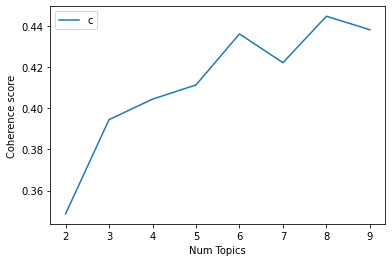

In [21]:
limit=10; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [22]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3486
Num Topics = 3  has Coherence Value of 0.3944
Num Topics = 4  has Coherence Value of 0.4044
Num Topics = 5  has Coherence Value of 0.4113
Num Topics = 6  has Coherence Value of 0.4361
Num Topics = 7  has Coherence Value of 0.4221
Num Topics = 8  has Coherence Value of 0.4447
Num Topics = 9  has Coherence Value of 0.4381


In [35]:
# Select the model and print the topics
optimal_model = model_list[3] # canviar pel que vulgui
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.110*"size" + 0.087*"fit" + 0.060*"small" + 0.053*"order" + 0.038*"large" '
  '+ 0.034*"run" + 0.024*"petite" + 0.024*"medium" + 0.023*"big" + '
  '0.020*"tight"'),
 (1,
  '0.130*"dress" + 0.047*"make" + 0.044*"fabric" + 0.026*"beautiful" + '
  '0.025*"feel" + 0.021*"cut" + 0.019*"flattering" + 0.016*"material" + '
  '0.014*"line" + 0.013*"shape"'),
 (2,
  '0.101*"wear" + 0.044*"buy" + 0.044*"love" + 0.033*"great" + 0.026*"perfect" '
  '+ 0.025*"purchase" + 0.023*"comfortable" + 0.021*"sweater" + 0.021*"soft" + '
  '0.021*"fall"'),
 (3,
  '0.080*"top" + 0.078*"color" + 0.029*"shirt" + 0.023*"nice" + 0.022*"pretty" '
  '+ 0.021*"back" + 0.021*"sleeve" + 0.020*"love" + 0.018*"picture" + '
  '0.016*"detail"'),
 (4,
  '0.040*"love" + 0.036*"long" + 0.034*"great" + 0.032*"short" + '
  '0.030*"length" + 0.029*"work" + 0.026*"good" + 0.025*"waist" + 0.023*"pant" '
  '+ 0.023*"skirt"')]


In [36]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=df['review_text']):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=df['review_text'])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.2243,"wear, buy, love, great, perfect, purchase, com...",Absolutely wonderful - silky and sexy and comf...
1,1,0.0,0.2355,"size, fit, small, order, large, run, petite, m...",Love this dress! it's sooo pretty. i happene...
2,2,0.0,0.2967,"size, fit, small, order, large, run, petite, m...",I had such high hopes for this dress and reall...
3,3,2.0,0.2490,"wear, buy, love, great, perfect, purchase, com...","I love, love, love this jumpsuit. it's fun, fl..."
4,4,3.0,0.2344,"top, color, shirt, nice, pretty, back, sleeve,...",This shirt is very flattering to all due to th...
5,5,4.0,0.2401,"love, long, great, short, length, work, good, ...","I love tracy reese dresses, but this one is no..."
6,6,3.0,0.2492,"top, color, shirt, nice, pretty, back, sleeve,...",I aded this in my basket at hte last mintue to...
7,7,4.0,0.2439,"love, long, great, short, length, work, good, ...","I ordered this in carbon for store pick up, an..."
8,8,0.0,0.2527,"size, fit, small, order, large, run, petite, m...",I love this dress. i usually get an xs but it ...
9,9,0.0,0.2523,"size, fit, small, order, large, run, petite, m...","I'm 5""5' and 125 lbs. i ordered the s petite t..."


In [37]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,2.0,"wear, buy, love, great, perfect, purchase, com...",4930.0,0.2179
1.0,0.0,"size, fit, small, order, large, run, petite, m...",4257.0,0.1881
2.0,0.0,"size, fit, small, order, large, run, petite, m...",5280.0,0.2333
3.0,2.0,"wear, buy, love, great, perfect, purchase, com...",4310.0,0.1905
4.0,3.0,"top, color, shirt, nice, pretty, back, sleeve,...",3851.0,0.1702
...,...,...,...,...
23481.0,NaN,NaN,NaN,NaN
23482.0,NaN,NaN,NaN,NaN
23483.0,NaN,NaN,NaN,NaN
23484.0,NaN,NaN,NaN,NaN


In [38]:
df_final = pd.merge(df_dominant_topic, df['rating'], how='inner', left_index=True, right_index=True)
df_final.head()


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,rating
0,0,2.0,0.2243,"wear, buy, love, great, perfect, purchase, com...",Absolutely wonderful - silky and sexy and comf...,4
1,1,0.0,0.2355,"size, fit, small, order, large, run, petite, m...",Love this dress! it's sooo pretty. i happene...,5
2,2,0.0,0.2967,"size, fit, small, order, large, run, petite, m...",I had such high hopes for this dress and reall...,3
3,3,2.0,0.2490,"wear, buy, love, great, perfect, purchase, com...","I love, love, love this jumpsuit. it's fun, fl...",5
4,4,3.0,0.2344,"top, color, shirt, nice, pretty, back, sleeve,...",This shirt is very flattering to all due to th...,5


In [39]:
df_final.groupby('Dominant_Topic').rating.value_counts()

Dominant_Topic  rating
0.0             5         2614
                4         1011
                3          622
                2          351
                1          165
1.0             5         2249
                4          912
                3          530
                2          265
                1          137
2.0             5         2796
                4         1111
                3          638
                2          341
                1          201
3.0             5         2320
                4          903
                3          496
                2          289
                1          147
4.0             5         2119
                4          771
                3          428
                2          236
                1          146
Name: rating, dtype: int64

In [40]:
df_final.groupby('Dominant_Topic').rating.mean()

Dominant_Topic
0.0    4.166912
1.0    4.190081
2.0    4.171614
3.0    4.193742
4.0    4.211081
Name: rating, dtype: float64

In [41]:
df_final.Dominant_Topic.value_counts()

2.0    5087
0.0    4763
3.0    4155
1.0    4093
4.0    3700
Name: Dominant_Topic, dtype: int64